In [1]:
import numpy as np
import pandas as pd
# import requests
import textstat
import bs4
import re
from nytapi import nytAPI
import string
from tqdm import tqdm
from collections import Counter
import json
import os
import matplotlib.pyplot as plt

import config

%matplotlib inline

In [2]:
def load_headlines(datetimeindex, savefile=None, **kwargs):
    """Use nytimes API to read in headlines
    
    if savefile, path of json file to save output to
    
    returns dictionary with all returned headlines for each date,
    given options passed to api via kwargs
    
    **This is very slow** as 6 seconds are added between every
    API call
    """
    
    if savefile is not None:
        if os.path.isfile(savefile):
            overwrite = input(f'{savefile} exists. Do you want to overwite? [y/n] ')
            if not overwrite.lower().startswith('y'):
                print('Exiting. Please specify a different file to save to.')
                return
                
    all_headlines = {}
    for date in tqdm(datetimeindex.strftime('%Y%m%d')):
        # sort oldest for uniquness page to page
        result_tot = api.search_iterative(begin_date=date,
                                          end_date=date,
                                          **kwargs)

        headlines = [res['headline']['main'] for res in result_tot]
        all_headlines[date] = headlines
    
    if savefile is not None:
        d_to_json = json.dumps(all_headlines)
        with open(savefile, 'w') as f:
            f.write(d_to_json)
    
    return all_headlines

In [3]:
def calc_mentions(text, names):
    """Calculate if mentioned in text for each name
    
    text is a list of strings with words to check
        each item in list should be a headline!
    names is a list of names, either first/last or just one
    
    returns boolean array
    
    NB: This algorithm assumes no candidate is mentioned
    more than once per headline
    """
    
    if not (isinstance(text, list) or isinstance(text, tuple)):
        c = Counter(re.split(f'[{string.punctuation}' +  ' ’]', text.lower()))
    else:
        all_words = []
        for sample in text:
            # split on all spaces and punctuation, including a special '’' character
            sample = re.split(f'[{string.punctuation}' +  ' ’]', sample.lower())
            all_words += sample
        c = Counter(all_words)
    names = [name.lower() for name in names]
    
    return [c[name] for name in names]

In [4]:
def random_article(mention_df, includes, excludes=None):
    """Given included names, selects a random article
    
    if excludes is not None, excludes articles contining 
        excluded names
    """
    
    mention_df = mention_df.astype(bool)
    if not isinstance(includes, list) and not isinstance(includes, tuple):
        includes = [includes]
    query = ' and '.join([f'{name} == 1' for name in includes])
    if excludes is not None:
        if not isinstance(excludes, list) and not isinstance(excludes, tuple):
            includes = [excludes]
        query += ' and '
        query += ' and '.join([f'{name} == 0' for name in excludes])
    
    selection = df.query(query)
    return selection.sample(1)['Headline'].values[0]

In [5]:
# Use API to populate dictionary if it doesn't exist
# This takes a while, since we wait 6 seconds between
# each API call
api = nytAPI(config.api_key)
headline_dict = load_headlines(pd.date_range('20180101', '20200307', freq='D'),
                               savefile='headlines.json',
                               fq={'source':'The New York Times', 
                                          'document_type':'article',
                                          'type_of_material':'news', 
                                          'section_name':'U.S.'},
                               facet_fields=['source'],
                               sort='oldest')

headlines.json exists. Do you want to overwite? [y/n] n
Exiting. Please specify a different file to save to.


In [6]:
# It exists, so load it
with open('headlines.json', 'r') as f:
    headline_dict = json.load(f)

In [7]:
df = pd.DataFrame(0, index=pd.MultiIndex.from_tuples([(key, i) 
                                                      for key in headline_dict
                                                      for i in range(len(headline_dict[key])) ], 
                                                      names=['Date', 'Headline']),
                 columns=['Sanders', 'Warren', 'Biden', 
                                'Buttigieg', 'Klobuchar', 'Yang', 'Bloomberg',
                                'Trump'])
df.index = df.index.set_levels([pd.to_datetime(df.index.levels[0]), df.index.levels[1]])
df = df.sort_index(level=0)

In [8]:
df = df.apply(lambda x: pd.Series(calc_mentions(headline_dict[x.name[0].strftime('%Y%m%d')][x.name[1]],
                                 df.columns), index=df.columns), axis=1)
df['Headline'] = [headline_dict[key][i] for key in headline_dict for i in range(len(headline_dict[key]))]

In [9]:
# a handful of headlines repeat a name; set these to 1
df = df.replace(range(2, 10), 1)

In [10]:
df_bool = df.iloc[:, :-1].astype(bool)

In [11]:
cross_cor_df = pd.DataFrame(0, index=df.columns[:-1], columns=df.columns[:-1])

for i in range(len(df.columns[:-1])):
    for j in range(len(df.columns[:-1])):
        cross_cor_df.iloc[i, j] = df_bool.loc[(df_bool.iloc[:, i]) 
               & (df_bool.iloc[:, j]) 
               & (df_bool.iloc[:, [k for k in range(len(df.columns[:-1])) 
                                   if k!=i and k!=j]].sum(axis=1) == 0)].shape[0]

In [12]:
percent_df = (100 * 
               cross_cor_df.div(cross_cor_df
              .sum(axis=1), axis='rows'))
percent_df['Total Mentions'] = cross_cor_df.sum(axis=1)
              
display(percent_df.style.format('{:.2f}%'.format, subset=percent_df.columns[:-1])
                                       .background_gradient(cmap='Blues', 
                                                            subset=percent_df.columns[:-1])
                                       .set_properties(**{'width':'80px'}))

,Sanders,Warren,Biden,Buttigieg,Klobuchar,Yang,Bloomberg,Trump,Total Mentions
Sanders,73.18%,10.00%,10.00%,2.73%,0.00%,0.45%,1.36%,2.27%,220
Warren,11.76%,68.98%,8.02%,2.67%,1.07%,0.00%,2.14%,5.35%,187
Biden,7.61%,5.19%,70.59%,0.69%,0.69%,0.00%,0.35%,14.88%,289
Buttigieg,5.83%,4.85%,1.94%,84.47%,2.91%,0.00%,0.00%,0.00%,103
Klobuchar,0.00%,5.71%,5.71%,8.57%,74.29%,0.00%,0.00%,5.71%,35
Yang,4.17%,0.00%,0.00%,0.00%,0.00%,91.67%,0.00%,4.17%,24
Bloomberg,3.75%,5.00%,1.25%,0.00%,0.00%,0.00%,73.75%,16.25%,80
Trump,0.14%,0.29%,1.23%,0.00%,0.06%,0.03%,0.37%,97.88%,3496


In [13]:
debates = pd.read_csv('debates.txt', '\t', header=None, names=['Dates'])
debates = debates.set_index(pd.to_datetime(debates['Dates']))

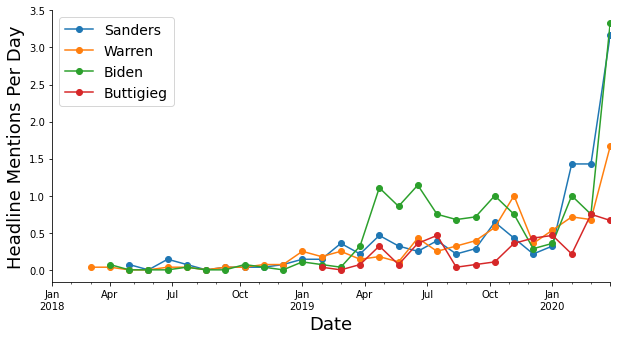

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
temp_df = (df.groupby(level=0).sum()).loc[:, ['Sanders', 'Warren', 'Biden', 
                'Buttigieg']].resample('4W').mean()
for name in temp_df.columns:
    (temp_df.loc[temp_df[name].index < temp_df[name]
            .loc[(temp_df[name] > 0)].index[0], name]) = np.nan
temp_df.plot(marker='o', ax=ax)
ax.set_ylabel('Headline Mentions Per Day', fontsize=18)
ax.set_xlabel('Date', fontsize=18)
ax.legend(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

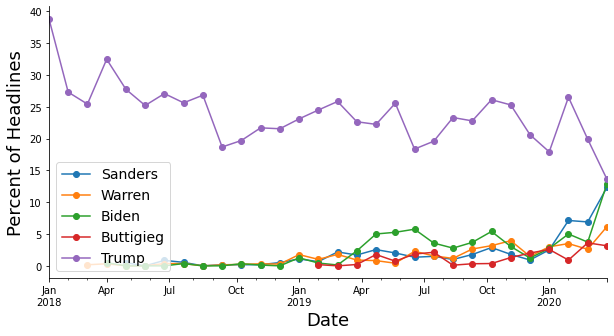

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
temp_df = (100 * df.groupby(level=0).sum() / df.groupby(level=0).count()).loc[:, ['Sanders', 'Warren', 'Biden', 
                'Buttigieg', 'Trump']].resample('4W').mean()
for name in temp_df.columns:
    (temp_df.loc[temp_df[name].index < temp_df[name]
            .loc[(temp_df[name] > 0)].index[0], name]) = np.nan
temp_df.plot(marker='o', ax=ax)
ax.set_ylabel('Percent of Headlines', fontsize=18)
ax.set_xlabel('Date', fontsize=18)
ax.legend(fontsize=14, loc='lower left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

There has been a steady increase in the number of U.S. section news articles. Is this a real trend? Is this an issue with the API?

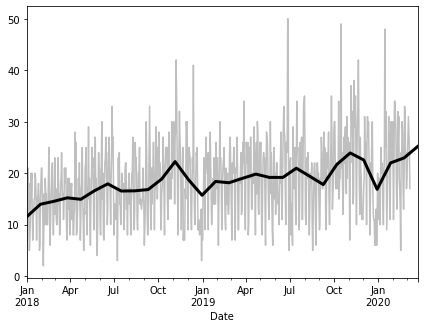

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 5)
df.groupby(level=0).size().plot(ax=ax, color='grey', alpha=0.5)
df.groupby(level=0).size().resample('4W').mean().plot(ax=ax, lw=3, color='black')